## Reload data

In [1]:
import pandas as pd

# data_path = "data/train2_norm_sampled_10k.pkl"  # 10k
data_path = "data/train2_norm_sampled_100k.pkl"  # 100k
# data_path = "data/train2_norm_sampled_1M.pkl"  # 1M

# data_path = "data/train2_norm_sampled.pkl"  # 3.09M, upsampled & downsampled, 3.090,617 samples
# data_path = "data/train2_norm_resampled.pkl"  # all upsampled without downsampling

df_all_norm = pd.read_pickle(data_path)

In [2]:
len(df_all_norm)

100000

In [3]:
import torch
from torch.autograd import Variable

x = df_all_norm[["CO+CO2", "H*", "O*", "C*"]]
y = df_all_norm[["n2_out"+ f"{v}" for v in range(1, 51)]]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

x = torch.tensor(x.values, device=device)
y = torch.tensor(y.values, device=device)

device = cuda


In [4]:
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline


def plot_3d_subplot(x, y, savepath):
    '''
     x,y type: numpy 2darray
    '''
    fig = plt.figure(figsize=(20, 10))
    xline, yline, zline1, zline2 = x[:, 0], x[:, 1], y[:, 0], y[:, 1]

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.set_xlabel('CO+CO2', fontsize=10)
    ax1.set_ylabel('N2', fontsize=10)
    ax1.set_zlabel('W1', fontsize=10)
    ax1.scatter3D(xline, yline, zline1, c=zline1, cmap=cm.coolwarm)

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_xlabel('CO+CO2', fontsize=10)
    ax2.set_ylabel('N2', fontsize=10)
    ax2.set_zlabel('W2', fontsize=10)
    ax2.scatter3D(xline, yline, zline2, c=zline2, cmap=cm.coolwarm)

    #plt.savefig(savepath)

Start time = 2021-11-22 21:41:12.483324
End time = 2021-11-22 21:41:12.591098


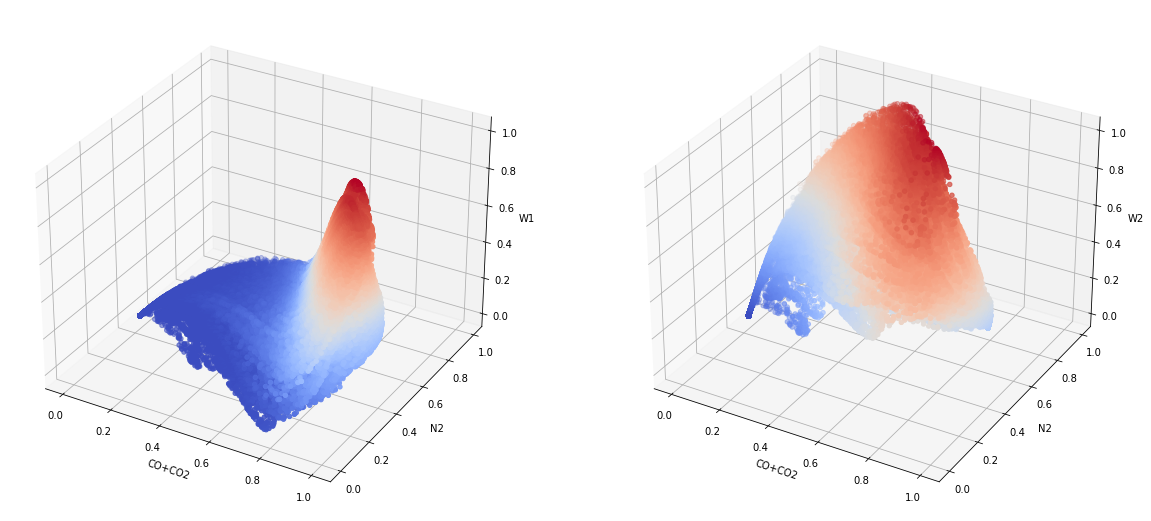

In [5]:
import datetime

print(f"Start time = {datetime.datetime.now()}")
plot_3d_subplot(x[:, :2].cpu().data.numpy(), y.cpu().data.numpy(), f"result/3D_plot-ann2-W-target.png")
print(f"End time = {datetime.datetime.now()}")

# Model training

In [6]:
import torch.utils.data as Data

torch.manual_seed(1)    # reproducible

BATCH_SIZE = 256  # x.shape[0]

flame_dataset = Data.TensorDataset(x, y)
loader = Data.DataLoader(dataset=flame_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=False, )

In [7]:
EPOCH = 2000
lr = 0.001  # 0.01
decayRate = 0.96
token = f"epoch={EPOCH}-lr={lr:.3f}-decay={decayRate:.2f}"

In [8]:
from torch.nn.modules.loss import _Loss
import torch.nn.functional as F
from torch import Tensor

class FlameLoss(_Loss):
    __constants__ = ['reduction']

    def __init__(self, size_average=None, reduce=None, reduction: str = 'sum') -> None:
        super(FlameLoss, self).__init__(size_average, reduce, reduction)

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        return torch.sum((target + 1) * (input - target) ** 2)

Start time = 2021-11-22 21:41:57.441936
Running time = 0:43:11.627745
Final MSEloss=2030.027587890625


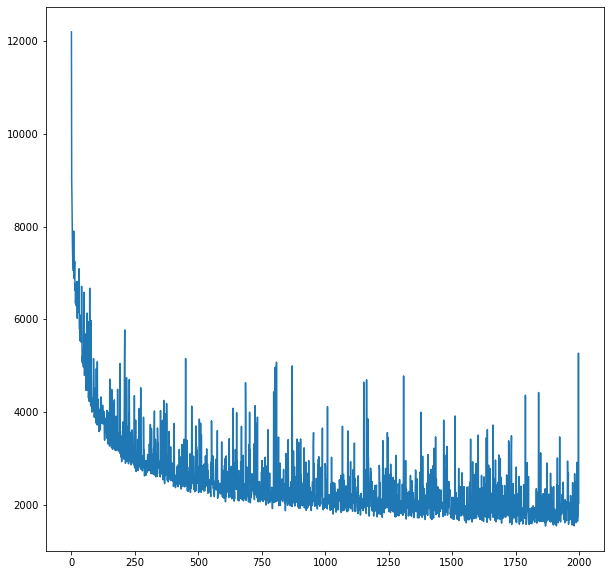

In [9]:
import imageio
from mpl_toolkits import mplot3d
import datetime
import numpy as np

net = torch.nn.Sequential(
        torch.nn.Linear(4, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 50),
    ).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=lr)
lr_decay = torch.optim.lr_scheduler.ExponentialLR(optimizer, decayRate)  # lr*gamma^step

loss_values = []

start_time = datetime.datetime.now()
print(f"Start time = {start_time}")

for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader):
        b_x = Variable(batch_x).to(device)
        b_y = Variable(batch_y).to(device)

        y_pred = net(b_x.float())
        loss = torch.nn.MSELoss(reduction='sum')(y_pred, b_y.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # evaluate model:
    net.eval()
    with torch.no_grad():
        y_pred = net(x.float())
        mseLoss = torch.nn.MSELoss(reduction='sum')(y_pred, y.float())
        loss_values.append(mseLoss.cpu())

    # enable training
    net.train()
    # lr_decay.step()

running_time = datetime.datetime.now() - start_time
print(f"Running time = {running_time}")
print(f"Final MSEloss={mseLoss}")

fig = plt.figure(figsize=(10, 10))
plt.plot(loss_values)
# plt.savefig(f"result/3D_plot-ann2-W-train-{token}-loss={mseLoss:.6f}.png")
# np.savetxt(f"result/3D_plot-ann2-W-train-{token}-loss={mseLoss:.6f}.csv", loss_values, delimiter =", ", fmt='%s')

In [10]:
# fig = plt.figure(figsize=(10, 10))
# plt.plot(loss_values[-200:])
# print(f"loss[500]={loss_values[500]}, loss[-200]={loss_values[-200]}, loss[-1]={loss_values[-1]},")

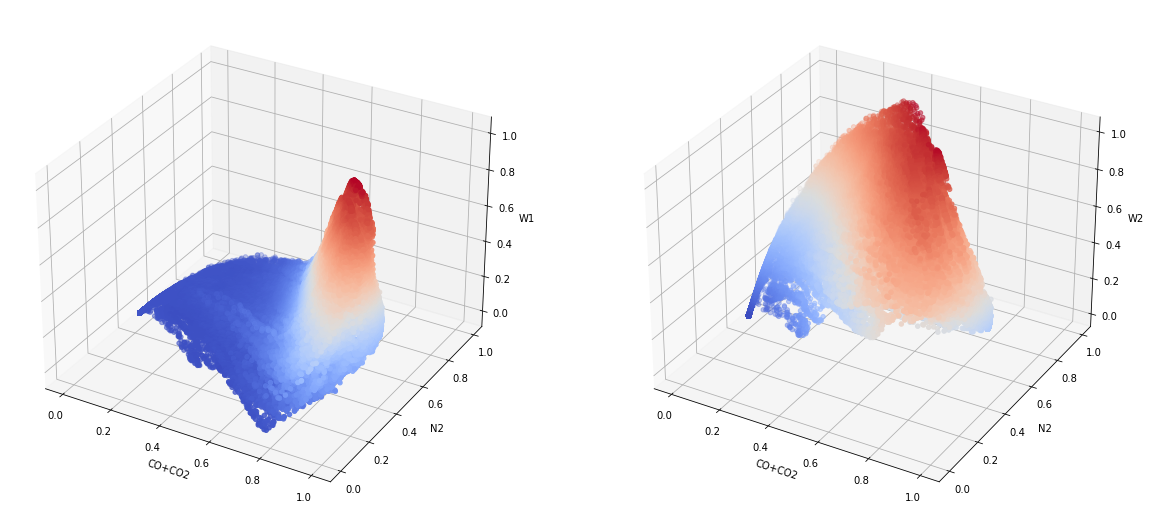

In [11]:
plot_3d_subplot(x[:, :2].cpu().data.numpy(), y_pred.cpu().data.numpy(), f"result/3D_plot-ann2-W-{token}-loss={mseLoss:.6f}.png")

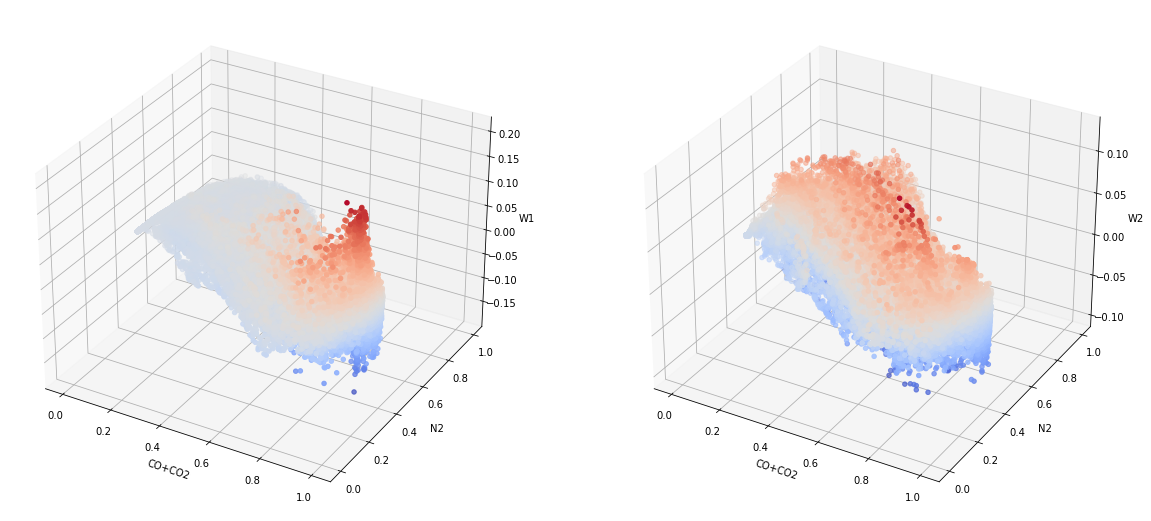

In [12]:
y_err = (y_pred-y).cpu().data.numpy()
plot_3d_subplot(x[:, :2].cpu().data.numpy(), y_err, f"result/3D_plot-ann2-W-{token}-err-loss={mseLoss:.6f}.png")

In [13]:
std_err = np.abs(y_err).max(axis=0)

print(f"Maximum norm err={max(std_err)}, W1 maximum norm err={std_err[0]}, W2 maximum norm err={std_err[1]}")

Maximum norm err=0.6186303156764686, W1 maximum norm err=0.20119240232017654, W2 maximum norm err=0.12397795805087719


In [14]:
print("loss value\tMax err\tW1 err\tW2 err\tRelative loss\tRuntime")
print(f"{mseLoss}\t{max(std_err)}\t{std_err[0]}\t{std_err[1]}\t{mseLoss.cpu().data.numpy()/len(y_err)*3090617}\t{running_time}")

loss value	Max err	W1 err	W2 err	Relative loss	Runtime
2030.027587890625	0.6186303156764686	0.20119240232017654	0.12397795805087719	62740.3777360376	0:43:11.627745
